In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

from scipy.optimize import minimize_scalar, brute
import scipy.optimize as optimize

%matplotlib inline

In [4]:
plt.style.use('seaborn-whitegrid')
img_path = "../reports/figures/"

In [38]:
# Task of interest
MU = 1.0
SIGMA = 1.0  # All formulas assume SIGMA=1.0, Do not change this value
P = 0.8

# The bias toward the class +MU if p > 0.5

In [47]:
def get_cdf(a, mean, std):
    a_norm = (a - mean) / std
    return norm.cdf(a_norm)

def err_h(h):
    # This is the error of a single hypothesis 'h'
    err = P * get_cdf(h, MU, SIGMA) + (1 - P) * (1 - get_cdf(h, -MU, SIGMA))
    err = np.round(err * 100, 4)
    return err

In [49]:
def create_dataset(samples, delta):
    n_x1 = int(np.round(samples * P))
    n_x0 = int(np.round(samples * (1 - P)))
    
    if n_x1 == 0 and n_x0 == 0:
        return 0, 0
    if n_x1 == 0 or n_x0 == 0:
        raise RuntimeError
    
    x0 = np.random.normal(-MU + delta, 1, size=n_x0)
    x1 = np.random.normal(MU + delta, 1, size=n_x1)
    return x0, x1

In [80]:
nrounds = 100000
nval = 10
mvals = [0, 5, 10, 15, 20, 30, 50]
mnorm = [m / nval for m in mvals]
dlist = [0, 0.1, 10]
all_errs = []

for delt in dlist:
    merr = []

    for m in mvals:
        errs = []
        for it in range(nrounds):
            x_t = create_dataset(nval, 0.0)
            x_ood = create_dataset(m, 0.0)

            x_0m = 0.5 * (np.mean(x_t[0]) + np.mean(x_ood[0]))
            x_1m = 0.5 * (np.mean(x_t[1]) + np.mean(x_ood[1]))

            x_mid = 0.5 * (np.mean(x_t[0]) + np.mean(x_t[1]))
            x_diff = (x_1m - x_0m)

            h = x_mid + (SIGMA**2 * np.log ( (1 - P) / P)) / x_diff
            errs.append(err_h(h))
        merr.append((np.mean(errs), np.std(errs)))
    all_errs.append(merr)

    print("Delta=" + str(delt))
    for m in merr:
        print(m)                       

Delta=0
(15.08185203, 5.539017344430263)
(12.615161772999999, 3.3887095263547446)
(12.251641391, 1.706029320476962)
(12.150795092, 1.415314585681894)
(12.112885011, 1.3714273442886538)
(12.068108896000002, 1.228269399363373)
(12.037610965, 1.1974242228438794)
Delta=0.1
(15.07662168, 5.479390856810908)
(12.598385322000002, 3.2310061862330683)
(12.254301185, 1.8017682094074963)
(12.154310567000001, 1.4589960765418934)
(12.118084498999998, 1.3619844211023924)
(12.069992413000001, 1.2396252757855244)
(12.034013498, 1.19854134341382)
Delta=10
(15.105122737, 5.585840629450659)
(12.600741729, 3.270634933980066)
(12.249365978000002, 1.7197927656736156)
(12.151397159, 1.407633022777609)
(12.107566084, 1.3175449503324375)
(12.068751123999997, 1.2521566142710492)
(12.034521975, 1.1820515767918078)


In [81]:
def make_loss_plot(errs, fname):
    fig = plt.figure(figsize=(5,3))
    color_idx = np.linspace(0, 1, len(dlist))
    
    for i in range(len(dlist)):
        col = plt.cm.RdYlGn_r(color_idx[i])
        err = np.array(errs[i])[:, 0]
        std = np.array(errs[i])[:, 1]
        plt.plot(mnorm, err, color=col)
        #plt.scatter(mnorm, err, alpha=0.5, s=5, color=col)
        #plt.errorbar(mnorm, std, color=col, capsize=4, capthick=1)
        markers, caps, bars = plt.errorbar(mnorm, err, std, color=col,  capsize=3, capthick=1)
        [bar.set_alpha(0.2) for bar in bars]

    plt.legend([str(d) for d in dlist], title='Delta', bbox_to_anchor = (1.05, 1.0))

    plt.xlabel("m/n, n=" + str(nval))
    plt.ylabel("Avg Risk")

    plt.savefig(img_path + fname, bbox_inches="tight")
    plt.show()
    

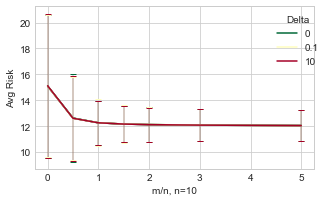

In [82]:
make_loss_plot(all_errs, "03-rr-multihead_class_priors.pdf")